In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime as dt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")
pd.set_option('max_colwidth',100)
pd.set_option('max_columns',20)

## I. load data

In [2]:
Submissions = pd.read_csv("train_test_data.csv", index_col=0)

In [3]:
Submissions.head()

,title_len,body_len,time,compound_score,num_early_comments,score
l8rf4k,22,0,1080.0,0.0000,28,413085.0
l6wu59,38,0,820.0,0.4019,5,315560.0
l78uct,29,0,1266.0,0.2732,181,280976.0
l846a1,36,0,1264.0,0.2732,259,252031.0
l6x130,291,183,829.0,-0.5267,5,222152.0


In [4]:
Submissions_df = Submissions.copy()

## II. Data exploration

In [5]:
Submissions_df.describe()

,title_len,body_len,time,compound_score,num_early_comments,score
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,73.453901,513.893617,870.851064,0.147403,29.127660,89279.262411
std,56.902482,2257.866495,420.138513,0.487901,55.068509,78751.055041
min,4.000000,0.000000,10.000000,-0.991400,0.000000,2.000000
25%,35.000000,0.000000,716.000000,0.000000,3.000000,12508.000000
50%,56.000000,0.000000,982.000000,0.000000,8.000000,108236.000000
75%,103.000000,0.000000,1209.000000,0.510600,27.000000,143507.000000
max,300.000000,23250.000000,1437.000000,0.999800,292.000000,413085.000000


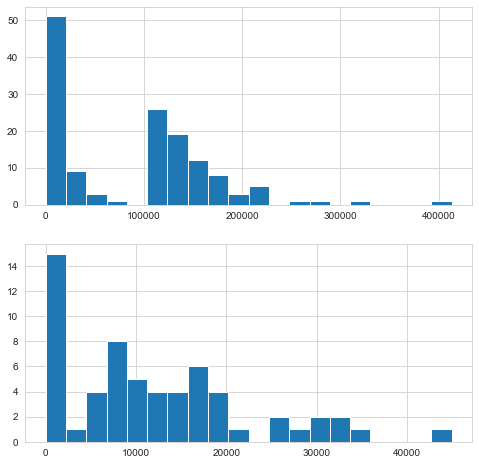

In [7]:
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.hist(Submissions_df.score, bins = 20, density = False)
plt.subplot(2,1,2)
plt.hist(Submissions_df[Submissions_df.score < 50000].score, bins = 20, density = False)


plt.show()

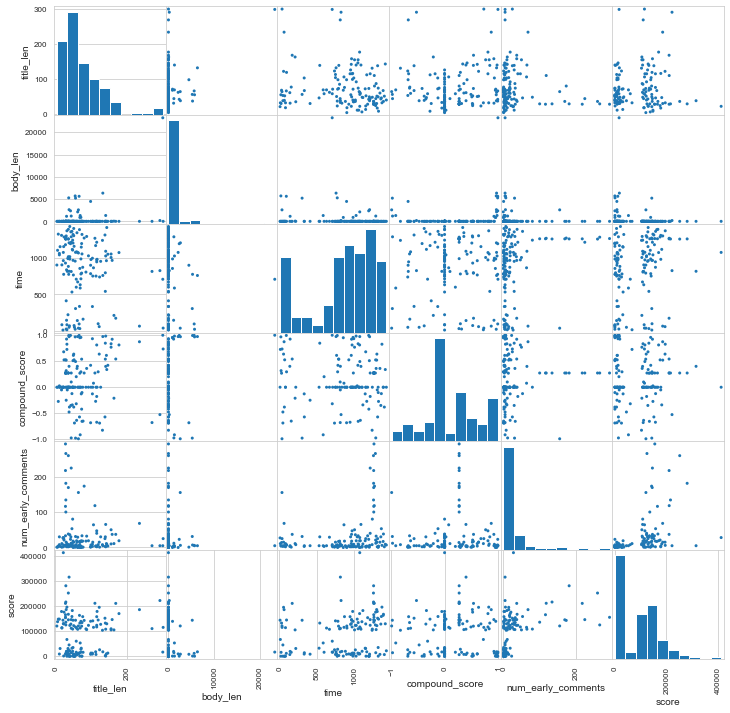

In [8]:
from pandas.plotting import scatter_matrix

scatter_matrix(Submissions_df, figsize = (12,12), alpha = 1)

plt.show()


In [9]:
Submissions_df.corr()['score'].sort_values()

body_len             -0.180585
compound_score       -0.003053
title_len             0.058791
time                  0.214426
num_early_comments    0.436051
score                 1.000000
Name: score, dtype: float64

## III. More data preprocessing

In [10]:
Submissions_df['content_len'] = Submissions_df['title_len']+Submissions_df['body_len']

In [35]:
c1 = Submissions_df['content_len']>500
c2 = Submissions_df['num_early_comments']>200
c3 = Submissions_df['score']>200000
outlier = Submissions_df[c1|c2|c3]

In [37]:
Submissions_df=Submissions_df.drop(outlier.index)

In [11]:
features = ['content_len', 'compound_score', 'time', 'num_early_comments']

In [38]:
Submissions_train = Submissions_df[features+['score']].sample(frac = .80, random_state = 614)
Submissions_test = Submissions_df[features+['score']].drop(Submissions_train.index)

In [47]:
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(Submissions_train)
Submissions_train_norm = pd.DataFrame(norm.transform(Submissions_train),columns=Submissions_train.columns, index=Submissions_train.index)
Submissions_test_norm = pd.DataFrame(norm.transform(Submissions_test),columns=Submissions_test.columns, index=Submissions_test.index)

In [48]:
Submissions_train_norm.columns

Index(['content_len', 'compound_score', 'time', 'num_early_comments', 'score'], dtype='object')

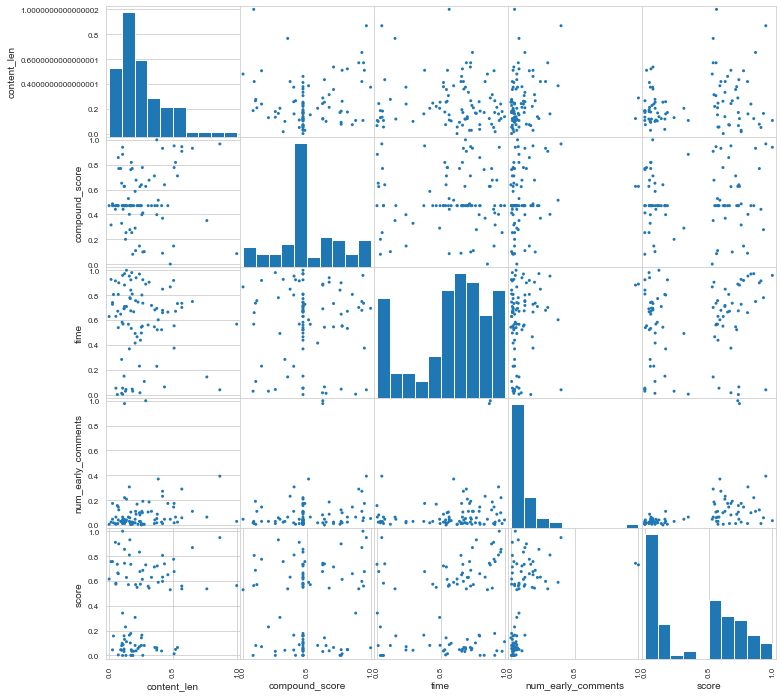

In [49]:
scatter_matrix(Submissions_train_norm, figsize = (12,12), alpha = 1)

plt.show()



In [51]:
Submissions_train_norm.corr()['score'].sort_values()

compound_score        0.070813
content_len           0.183361
time                  0.205606
num_early_comments    0.418870
score                 1.000000
Name: score, dtype: float64

## IV. Linear model

In [43]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [52]:
fit = sm.OLS(Submissions_train_norm['score'],sm.add_constant(Submissions_train_norm[features])).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     5.736
Date:                Thu, 27 May 2021   Prob (F-statistic):           0.000390
Time:                        11:03:07   Log-Likelihood:                -15.231
No. Observations:                  90   AIC:                             40.46
Df Residuals:                      85   BIC:                             52.96
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1754      0

In [53]:
reg = LinearRegression(copy_X = True)

reg.fit(Submissions_train_norm[features],Submissions_train_norm['score'])

LinearRegression()

In [56]:
print("beta_0_hat is",np.round(reg.intercept_,2), '(const)')
print("beta_1_hat is",np.round(reg.coef_[0],2),'(content_len)')
print("beta_2_hat is",np.round(reg.coef_[1],2),'(compound_score)')
print("beta_3_hat is",np.round(reg.coef_[2],2),'(time)')
print("beta_4_hat is",np.round(reg.coef_[3],2),'(num_early_comments)')


beta_0_hat is 0.18 (const)
beta_1_hat is 0.25 (content_len)
beta_2_hat is -0.02 (compound_score)
beta_3_hat is 0.16 (time)
beta_4_hat is 0.77 (num_early_comments)


In [ ]:
print("The training MSE is", np.sum(np.power(fit.resid,2))/len(Submissions_train_norm))

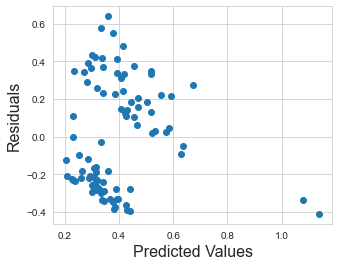

In [57]:
pred = reg.predict(Submissions_train_norm[features])
res = Submissions_train_norm['score'] - pred
plt.figure(figsize = (5,4))

plt.scatter(pred,res)

plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Residuals", fontsize=16)

plt.show()

## The following hasn't been checked.

In [ ]:
##Polynomial Regression with x1^2
Comments_train['title_len_sq'] = Comments_train['title_len']**2

In [ ]:
reg = LinearRegression(copy_X = True)

reg.fit(Comments_train[['title_len','title_len_sq','body_len','time','compound_score','num_early_comments']], Comments_train['score'])

In [ ]:
print("beta_0_hat is",np.round(reg.intercept_,2))
print("beta_1_hat is",np.round(reg.coef_[0],2))
print("beta_2_hat is",np.round(reg.coef_[1],2))
print("beta_3_hat is",np.round(reg.coef_[2],2))
print("beta_4_hat is",np.round(reg.coef_[3],2))
print("beta_5_hat is",np.round(reg.coef_[4],2))
print("beta_6_hat is",np.round(reg.coef_[5],2))

score = (50197.01) + -225.75* title_len + 2.38 * title_len^2 + -13.05* body_len + 26.6*time + 7988.35＊compound_score + 587.45＊num_early_comments

In [ ]:
print("The training MSE is", np.sum(np.power(fit.resid,2))/len(Comments_train))

In [ ]:
# Let's examine the residual plot
pred = reg.predict(Comments_train[['title_len','title_len_sq','body_len','time','compound_score','num_early_comments']])

res = Comments_train['score'] - pred

In [ ]:
plt.figure(figsize = (5,4))

plt.scatter(pred,res)

plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Residuals", fontsize=16)

plt.show()

In [ ]:
plt.close()

In [ ]:
# First add the interaction term
Comments_train['title_body'] = Comments_train['title_len']*Comments_train['body_len']

In [ ]:
reg = LinearRegression(copy_X = True)

reg.fit(Comments_train[['title_len','body_len','title_body','time','compound_score','num_early_comments']], Comments_train['score'])

In [ ]:
print("beta_0_hat is",np.round(reg.intercept_,2))
print("beta_1_hat is",np.round(reg.coef_[0],2))
print("beta_2_hat is",np.round(reg.coef_[1],2))
print("beta_3_hat is",np.round(reg.coef_[2],2))
print("beta_4_hat is",np.round(reg.coef_[3],2))
print("beta_5_hat is",np.round(reg.coef_[4],2))
print("beta_6_hat is",np.round(reg.coef_[5],2))

score = (30147.41) + 327.88* title_len + -12.97* body_len + -0.01* title_len*body_len+ 25.33*time + 6619.08*compound_score + 600.57＊num_early_comments

In [ ]:
# Let's re-examine the residual plot
pred = reg.predict(Comments_train[['title_len','body_len','title_body','time','compound_score','num_early_comments']])

res = Comments_train['score'] - pred

In [ ]:
plt.figure(figsize = (5,4))

plt.scatter(pred, res)

plt.xlabel("Predicted Values", fontsize=16)
plt.ylabel("Residuals", fontsize=16)

plt.show()